## About the dataset

This dataset is taken from Kaggle: [Sleep Data](https://www.kaggle.com/datasets/danagerous/sleep-data?select=sleepdata.csv). It tracks the sleep cycles of a particular user from [2014-2018](../data/raw/sleepdata.csv) and [2018-2022](../data/raw/sleepdata_2.csv).

Both datasets have Start, End, and Sleep Quality (target) columns. Both datasets also have a few other faetures, but the data from 2018-2022 (sleepdata_2.csv) contains additional columns that the 2014-2018 (sleepdata.csv) data does not have. 

## Imports

In [487]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from datetime import datetime



## Initial cleaning to stack datasets

In [488]:
df1 = pd.read_csv("../data/raw/sleepdata.csv", sep=";", parse_dates=["Start", "End"])
print(df1.shape)
df1.head()

(887, 8)


,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [489]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Start             887 non-null    datetime64[ns]
 1   End               887 non-null    datetime64[ns]
 2   Sleep quality     887 non-null    object        
 3   Time in bed       887 non-null    object        
 4   Wake up           246 non-null    object        
 5   Sleep Notes       652 non-null    object        
 6   Heart rate        162 non-null    float64       
 7   Activity (steps)  887 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 55.6+ KB


In [490]:
df2 = pd.read_csv("../data/raw/sleepdata_2.csv", sep=";", parse_dates=["Start", "End"])
print(df2.shape)
df2.head()

(921, 21)


,Start,End,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Time in bed (seconds),Time asleep (seconds),Time before sleep (seconds),Window start,Window stop,Did snore,Snore time,Weather temperature (°C),Weather type,Notes
0,2019-05-12 23:26:13,2019-05-13 06:11:03,60%,0%,NaN,0,8350,Normal,NaN,NaN,...,24289.2,22993.8,161.9,2019-05-13 06:00:00,2019-05-13 06:00:00,True,92.0,0.0,No weather,NaN
1,2019-05-13 22:10:31,2019-05-14 06:10:42,73%,0%,NaN,0,4746,Normal,NaN,NaN,...,28810.2,25160.9,192.1,2019-05-14 05:50:00,2019-05-14 05:50:00,True,0.0,0.0,No weather,NaN
2,2019-05-14 21:43:00,2019-05-15 06:10:41,86%,96%,NaN,0,4007,Normal,NaN,NaN,...,30461.5,28430.8,203.1,2019-05-15 05:50:00,2019-05-15 05:50:00,True,74.0,0.0,No weather,NaN
3,2019-05-15 23:11:51,2019-05-16 06:13:59,77%,92%,NaN,0,6578,Normal,NaN,NaN,...,25327.6,23132.5,168.9,2019-05-16 05:50:00,2019-05-16 05:50:00,True,0.0,0.0,No weather,NaN
4,2019-05-16 23:12:13,2019-05-17 06:20:32,78%,94%,NaN,0,4913,Normal,NaN,NaN,...,25698.4,22614.6,171.3,2019-05-17 05:50:00,2019-05-17 05:50:00,True,188.0,0.0,No weather,NaN


In [491]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        921 non-null    datetime64[ns]
 1   End                          921 non-null    datetime64[ns]
 2   Sleep Quality                921 non-null    object        
 3   Regularity                   921 non-null    object        
 4   Mood                         0 non-null      float64       
 5   Heart rate (bpm)             921 non-null    int64         
 6   Steps                        921 non-null    int64         
 7   Alarm mode                   921 non-null    object        
 8   Air Pressure (Pa)            492 non-null    float64       
 9   City                         487 non-null    object        
 10  Movements per hour           921 non-null    float64       
 11  Time in bed (seconds)        921 non-null    

In [492]:
pd.to_timedelta(df1["Time in bed"] + ":00").dt.total_seconds() / 3600

0      8.533333
1      0.266667
2      8.500000
3      7.533333
4      6.733333
         ...   
882    9.133333
883    7.183333
884    8.933333
885    9.216667
886    8.916667
Name: Time in bed, Length: 887, dtype: float64

In [493]:
df1["Time in bed (hr)"] = pd.to_timedelta(df1["Time in bed"] + ":00").dt.total_seconds() / 3600

In [494]:
df1 = df1.drop(columns=["Wake up", "Sleep Notes", "Time in bed"])
df2 = df2.drop(columns=["Mood", "Notes"])

In [495]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Start             887 non-null    datetime64[ns]
 1   End               887 non-null    datetime64[ns]
 2   Sleep quality     887 non-null    object        
 3   Heart rate        162 non-null    float64       
 4   Activity (steps)  887 non-null    int64         
 5   Time in bed (hr)  887 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 41.7+ KB


In [496]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        921 non-null    datetime64[ns]
 1   End                          921 non-null    datetime64[ns]
 2   Sleep Quality                921 non-null    object        
 3   Regularity                   921 non-null    object        
 4   Heart rate (bpm)             921 non-null    int64         
 5   Steps                        921 non-null    int64         
 6   Alarm mode                   921 non-null    object        
 7   Air Pressure (Pa)            492 non-null    float64       
 8   City                         487 non-null    object        
 9   Movements per hour           921 non-null    float64       
 10  Time in bed (seconds)        921 non-null    float64       
 11  Time asleep (seconds)        921 non-null    

In [497]:
df2["Time in bed (hr)"] = df2["Time in bed (seconds)"] / 3600
rows_to_move = ['Start', 'End', 'Sleep Quality', 'Heart rate (bpm)', 'Steps', 'Time in bed (hr)']
df2 = df2.drop(columns=["Time in bed (seconds)"])
row_order = rows_to_move + [c for c in df2.columns if c not in rows_to_move]
df2 = df2[row_order]


In [498]:
df1 = df1.rename(columns={"Heart rate": "Heart rate (bpm)", "Activity (steps)": "Steps"})
df2 = df2.rename(columns={"Sleep Quality": "Sleep quality"})

In [499]:
df1.head()

,Start,End,Sleep quality,Heart rate (bpm),Steps,Time in bed (hr)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,59.0,0,8.533333
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,72.0,0,0.266667
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,57.0,0,8.500000
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,NaN,0,7.533333
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,68.0,0,6.733333


In [500]:
df2.head()

,Start,End,Sleep quality,Heart rate (bpm),Steps,Time in bed (hr),Regularity,Alarm mode,Air Pressure (Pa),City,Movements per hour,Time asleep (seconds),Time before sleep (seconds),Window start,Window stop,Did snore,Snore time,Weather temperature (°C),Weather type
0,2019-05-12 23:26:13,2019-05-13 06:11:03,60%,0,8350,6.747000,0%,Normal,NaN,NaN,35.0,22993.8,161.9,2019-05-13 06:00:00,2019-05-13 06:00:00,True,92.0,0.0,No weather
1,2019-05-13 22:10:31,2019-05-14 06:10:42,73%,0,4746,8.002833,0%,Normal,NaN,NaN,78.6,25160.9,192.1,2019-05-14 05:50:00,2019-05-14 05:50:00,True,0.0,0.0,No weather
2,2019-05-14 21:43:00,2019-05-15 06:10:41,86%,0,4007,8.461528,96%,Normal,NaN,NaN,60.5,28430.8,203.1,2019-05-15 05:50:00,2019-05-15 05:50:00,True,74.0,0.0,No weather
3,2019-05-15 23:11:51,2019-05-16 06:13:59,77%,0,6578,7.035444,92%,Normal,NaN,NaN,45.2,23132.5,168.9,2019-05-16 05:50:00,2019-05-16 05:50:00,True,0.0,0.0,No weather
4,2019-05-16 23:12:13,2019-05-17 06:20:32,78%,0,4913,7.138444,94%,Normal,NaN,NaN,44.6,22614.6,171.3,2019-05-17 05:50:00,2019-05-17 05:50:00,True,188.0,0.0,No weather


In [501]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df = df.reset_index(drop=True)
print(df.shape)
df.iloc[886:890]

(1808, 19)


,Start,End,Sleep quality,Heart rate (bpm),Steps,Time in bed (hr),Regularity,Alarm mode,Air Pressure (Pa),City,Movements per hour,Time asleep (seconds),Time before sleep (seconds),Window start,Window stop,Did snore,Snore time,Weather temperature (°C),Weather type
886,2018-02-16 22:52:29,2018-02-17 07:48:04,91%,NaN,2291,8.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,2019-05-12 23:26:13,2019-05-13 06:11:03,60%,0.0,8350,6.747000,0%,Normal,NaN,NaN,35.0,22993.8,161.9,2019-05-13 06:00:00,2019-05-13 06:00:00,True,92.0,0.0,No weather
888,2019-05-13 22:10:31,2019-05-14 06:10:42,73%,0.0,4746,8.002833,0%,Normal,NaN,NaN,78.6,25160.9,192.1,2019-05-14 05:50:00,2019-05-14 05:50:00,True,0.0,0.0,No weather
889,2019-05-14 21:43:00,2019-05-15 06:10:41,86%,0.0,4007,8.461528,96%,Normal,NaN,NaN,60.5,28430.8,203.1,2019-05-15 05:50:00,2019-05-15 05:50:00,True,74.0,0.0,No weather


In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1808 non-null   datetime64[ns]
 1   End                          1808 non-null   datetime64[ns]
 2   Sleep quality                1808 non-null   object        
 3   Heart rate (bpm)             1083 non-null   float64       
 4   Steps                        1808 non-null   int64         
 5   Time in bed (hr)             1808 non-null   float64       
 6   Regularity                   921 non-null    object        
 7   Alarm mode                   921 non-null    object        
 8   Air Pressure (Pa)            492 non-null    float64       
 9   City                         487 non-null    object        
 10  Movements per hour           921 non-null    float64       
 11  Time asleep (seconds)        921 non-null  

### dummy & first baseline with no time

In [503]:
cols_over_half_nan = df.columns[df.isna().mean() >= 0.5].tolist()
cols_over_half_nan

['Air Pressure (Pa)', 'City', 'Window start', 'Window stop']

In [504]:
df = df.drop(columns=cols_over_half_nan)

In [505]:
df.shape

(1808, 15)

#### aside: outlier detection?

In [506]:
(df.iloc[1000:1005]["Time asleep (seconds)"] + df.iloc[1000:1005]["Time before sleep (seconds)"])/3600

1000    6.088722
1001    6.346472
1002    6.144750
1003    6.626500
1004    6.858389
dtype: float64

In [507]:
df.iloc[1000:1005]["Time in bed (hr)"]

1000    6.866972
1001    7.130861
1002    6.727806
1003    7.335611
1004    7.481861
Name: Time in bed (hr), dtype: float64

plotting histograms for outliers soon, but spotted the two (seconds) cols...hmm

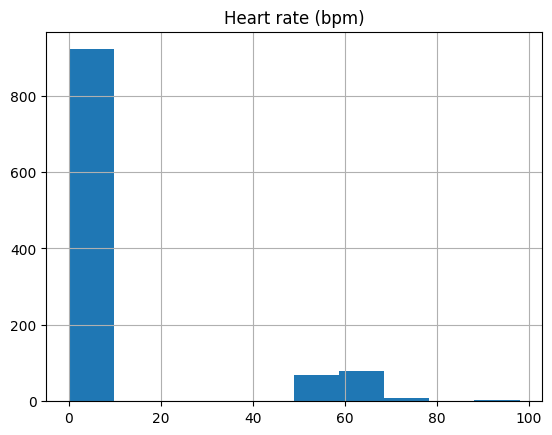

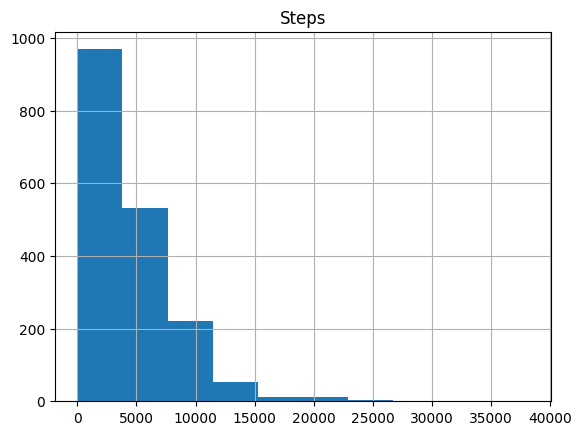

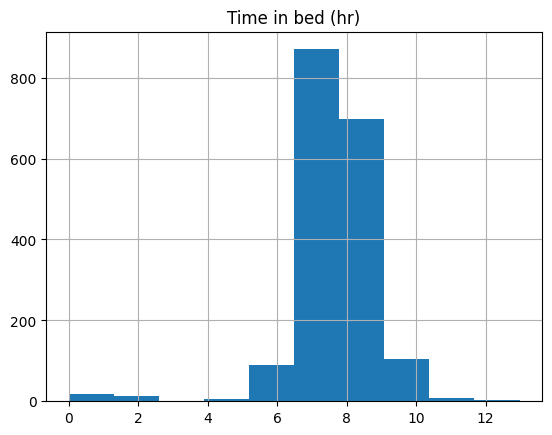

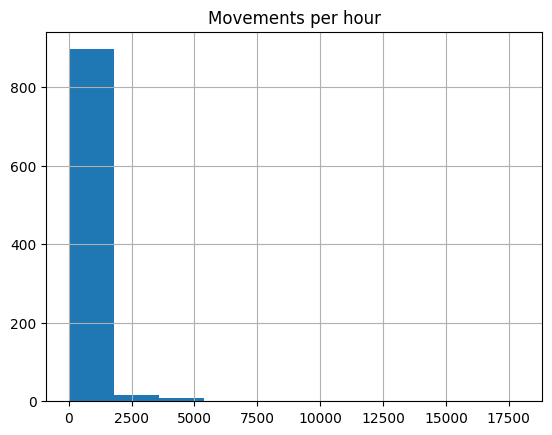

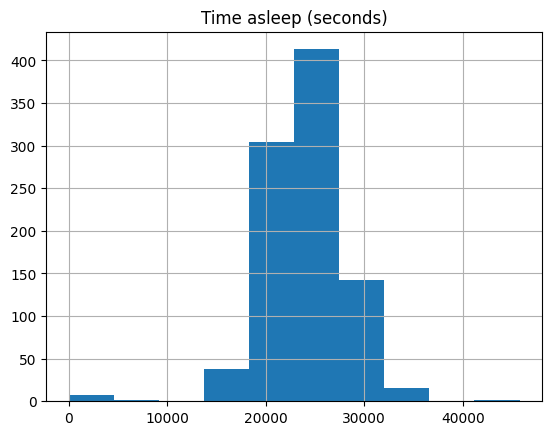

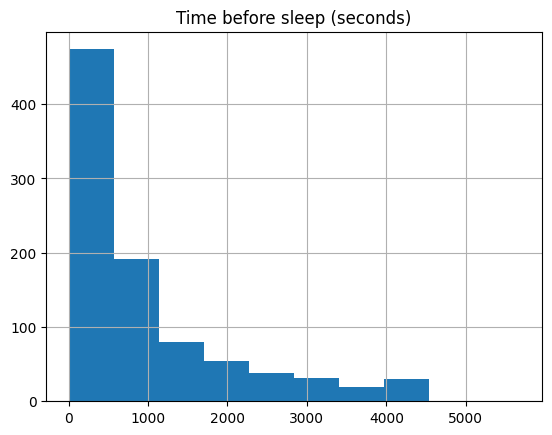

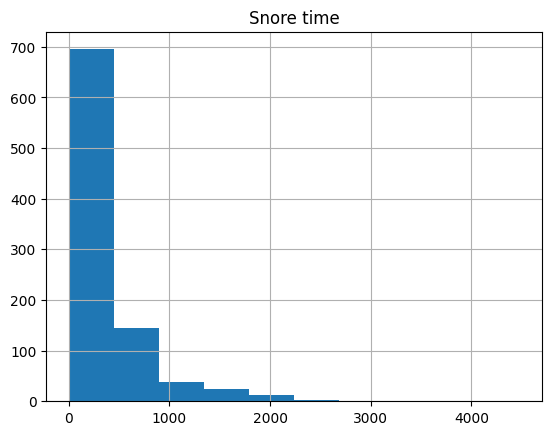

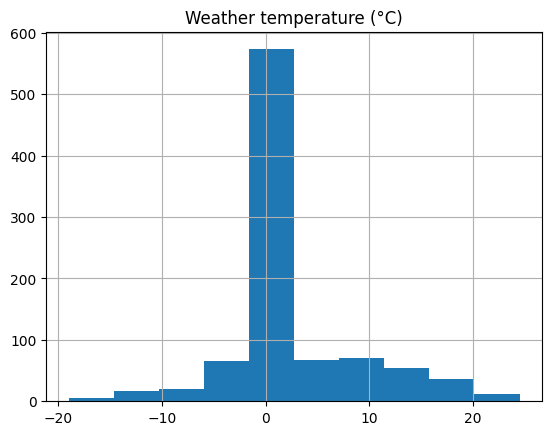

In [508]:
for col in df.select_dtypes("number").columns:  
    plt.figure()
    plt.title(col)
    df[col].hist()

biggest things are: remove naps, and 0 bpm heartrate?? 0 bpm heartrate first

In [509]:
df.isna().sum().sum()

np.int64(8708)

In [510]:
df2.describe()

,Start,End,Heart rate (bpm),Steps,Time in bed (hr),Air Pressure (Pa),Movements per hour,Time asleep (seconds),Time before sleep (seconds),Snore time,Weather temperature (°C)
count,921,921,921.0,921.000000,921.000000,492.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,2020-10-14 09:47:50.009772032,2020-10-14 17:26:11.588490752,0.0,5311.599349,7.640416,68.660163,174.277416,23912.683170,1001.556135,312.944300,2.142562
min,2019-05-12 23:26:13,2019-05-13 06:11:03,0.0,0.000000,0.514667,0.000000,0.000000,0.000000,0.000000,0.000000,-19.000000
25%,2020-02-14 21:08:43,2020-02-15 07:23:42,0.0,2299.000000,7.083500,0.000000,37.000000,21627.500000,449.900000,0.000000,0.000000
50%,2020-10-13 21:36:30,2020-10-14 05:09:08,0.0,4245.000000,7.617472,93.700000,49.600000,23919.000000,563.700000,148.000000,0.000000
75%,2021-06-07 21:57:36,2021-06-08 04:42:57,0.0,7452.000000,8.202806,94.400000,65.200000,26257.000000,1287.000000,440.000000,3.100000
max,2022-03-29 22:44:09,2022-03-30 05:11:15,0.0,38165.000000,12.973167,96.500000,17926.700000,45769.400000,5677.700000,4477.300000,24.500000
std,NaN,NaN,0.0,4396.822762,1.087971,41.845368,822.776299,4066.189356,1046.287777,455.472848,6.324558


In [511]:
# counting all non nan and non zero values
df["Heart rate (bpm)"].dropna().astype(bool).sum()

np.int64(162)

yeah, lets drop bpm. Nan values not encoded as nan are annoying!

In [512]:
df = df.drop(columns=["Heart rate (bpm)"])

now looking at filtering out naps

<Axes: >

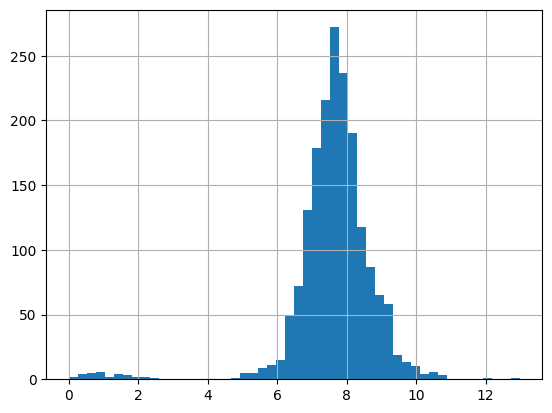

In [513]:
df["Time in bed (hr)"].hist(bins=50)

the gap in between 2 hr 30 min and 4 hr 30 min seems to be the difference between nap and sleep. lets filter out all naps this way

In [514]:
df = df[df["Time in bed (hr)"] >= 3.5]
df = df.reset_index(drop=True)
df

,Start,End,Sleep quality,Steps,Time in bed (hr),Regularity,Alarm mode,Movements per hour,Time asleep (seconds),Time before sleep (seconds),Did snore,Snore time,Weather temperature (°C),Weather type
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,0,8.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,0,8.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,0,7.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,0,6.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-03 00:34:57,2015-01-03 07:47:23,83%,0,7.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,2022-03-23 22:30:25,2022-03-24 06:03:07,72%,2521,7.545000,86%,Normal,45.1,25079.6,543.2,True,1080.0,4.6,Fog
1773,2022-03-24 21:33:46,2022-03-25 04:21:40,71%,3903,6.798361,77%,Normal,39.7,20803.0,489.5,True,695.7,4.0,Cloudy
1774,2022-03-26 21:14:23,2022-03-27 06:11:01,49%,13388,8.943917,-1%,Normal,82.7,24577.9,3649.1,True,506.4,-1.1,Cloudy
1775,2022-03-28 22:53:23,2022-03-29 04:50:36,77%,456,5.953778,22%,Normal,17.3,15860.8,428.7,True,60.0,6.1,Sunny


In [515]:
df.shape

(1777, 14)

there were about 30 naps in dataset

#### outlier aside finished

### Quick recap on all the dropping we've done so far:

Originally, we had 22 features between the two dataframes:
- In both dataframes (7)
    - Start
    - End
    - Sleep quality
    - Time in bed 
    - Sleep Notes/notes
    - Heart rate
    - Activity/steps

- In df1 only (2014-2018) (1)
    - Wake up (emoticon)

- In df2 only (2019-2022) (14)
    - Regularity
    - Mood
    - Alarm mode
    - Air Pressure
    - City
    - Movements per hour
    - Time asleep (seconds)
    - Time before sleep (seconds)
    - Window start
    - Window stop
    - Did snore
    - Snore time
    - Weather temperature (°C) 
    - Weather type<br><br><br>

In this EDA, I dropped:
- In both dataframes (2)
    - Sleep Notes/notes
    - Heart rate

- In df1 only (2014-2018) (1)
    - Wake up (emoticon)

- In df2 only (2019-2022) (5)
    - Mood
    - Air Pressure
    - City
    - Window start
    - Window stop<br><br><br>

Thus, the remaining features are:
- In both dataframes (5)
    - Start
    - End
    - Sleep quality
    - Time in bed 
    - Activity/steps

- In df1 only (2014-2018) (0)

- In df2 only (2019-2022) (9)
    - Regularity
    - Alarm mode
    - Movements per hour
    - Time asleep (seconds)
    - Time before sleep (seconds)
    - Did snore
    - Snore time
    - Weather temperature (°C) 
    - Weather type<br><br><br>

I'll try predicting with the rest of the features; notably,
- Regularity                     
- Alarm mode                     
- Movements per hour             
- Time asleep (seconds)          
- Time before sleep (seconds)    
- Did snore                      
- Snore time                     
- Weather temperature (°C)       
- Weather type      

only appear in the 2018-2022 dataset, so I'll try imputing by [using a model to predict missing values](https://www.youtube.com/watch?v=KWrZ59nLLSg)

### Actually imputing with a model now

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   object        
 3   Steps                        1777 non-null   int64         
 4   Time in bed (hr)             1777 non-null   float64       
 5   Regularity                   913 non-null    object        
 6   Alarm mode                   913 non-null    object        
 7   Movements per hour           913 non-null    float64       
 8   Time asleep (seconds)        913 non-null    float64       
 9   Time before sleep (seconds)  913 non-null    float64       
 10  Did snore                    913 non-null    object        
 11  Snore time                   913 non-null  

first, sleep quality and regularity are numeric but currently stored as strings, so convert to numeric

In [517]:
pct_cols = ["Sleep quality", "Regularity"]
df[pct_cols] = df[pct_cols].apply(lambda x: x.str.replace("%", "").astype(float))

In [518]:
df[pct_cols] = df[pct_cols] / 100
df.iloc[1000:1005]

,Start,End,Sleep quality,Steps,Time in bed (hr),Regularity,Alarm mode,Movements per hour,Time asleep (seconds),Time before sleep (seconds),Did snore,Snore time,Weather temperature (°C),Weather type
1000,2019-10-23 20:59:40,2019-10-24 06:04:21,0.92,3816,9.078222,0.94,Normal,49.8,28977.7,217.9,True,0.0,0.0,No weather
1001,2019-10-24 22:19:11,2019-10-25 07:07:17,0.92,2368,8.801639,0.89,Normal,47.6,29151.1,211.2,True,334.0,-0.5,Cloudy
1002,2019-10-25 21:47:32,2019-10-26 07:09:21,0.78,7632,9.363722,0.88,Normal,66.0,29776.6,3258.6,True,0.0,0.0,No weather
1003,2019-10-27 22:34:04,2019-10-28 06:01:38,0.75,7076,7.459222,0.90,Normal,51.7,23899.4,179.0,True,65.0,0.0,No weather
1004,2019-10-28 22:29:22,2019-10-29 05:59:51,0.75,3601,7.508167,0.92,Normal,52.2,22074.0,1531.7,True,107.0,0.0,No weather


In [519]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Start                        1777 non-null   datetime64[ns]
 1   End                          1777 non-null   datetime64[ns]
 2   Sleep quality                1777 non-null   float64       
 3   Steps                        1777 non-null   int64         
 4   Time in bed (hr)             1777 non-null   float64       
 5   Regularity                   913 non-null    float64       
 6   Alarm mode                   913 non-null    object        
 7   Movements per hour           913 non-null    float64       
 8   Time asleep (seconds)        913 non-null    float64       
 9   Time before sleep (seconds)  913 non-null    float64       
 10  Did snore                    913 non-null    object        
 11  Snore time                   913 non-null  

wait...

i have an issue: i have data where the first part dosent have some features, but the part later on in time does. however, if i time series split it and then try imputing using a model which is what i wanna do, i cant because there is no data, or very little data to base it on and it will be inaccurate

if i dont time series split it and impute based on all of it then my test data is not truly unseen anymore...

i guess time to drop most of the cols then

In [520]:
df = df.drop(columns=[x for x in df.columns[5:]])

In [521]:
df["Steps"].dropna().astype(bool).sum()

np.int64(1360)

In [522]:
df["Steps"].dropna().astype(bool).value_counts()

Steps
True     1360
False     417
Name: count, dtype: int64

<Axes: >

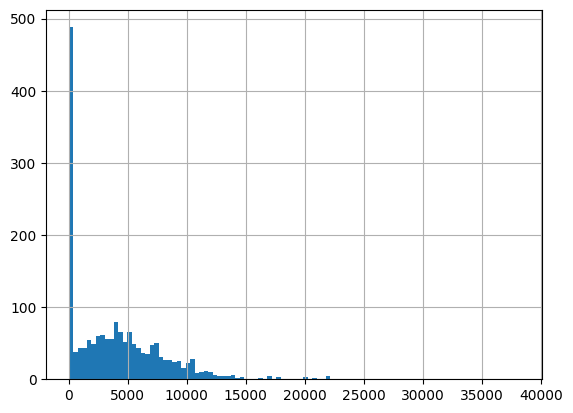

In [523]:
df["Steps"].hist(bins=100)

In [524]:
df.describe()

,Start,End,Sleep quality,Steps,Time in bed (hr)
count,1777,1777,1777.000000,1777.000000,1777.000000
mean,2018-10-09 20:25:29.123804416,2018-10-10 04:10:47.328081152,0.775245,4079.813168,7.751069
min,2014-12-29 22:57:49,2014-12-30 07:30:13,0.300000,0.000000,4.840194
25%,2016-10-02 23:29:07,2016-10-03 06:25:22,0.710000,121.000000,7.216667
50%,2019-06-09 00:25:05,2019-06-09 07:37:59,0.780000,3396.000000,7.700000
75%,2020-10-24 22:09:06,2020-10-25 05:18:38,0.850000,6388.000000,8.211972
max,2022-03-29 22:44:09,2022-03-30 05:11:15,1.000000,38165.000000,12.973167
std,NaN,NaN,0.116394,4174.490827,0.845441


theres at least 1 outlier, but thats not really data quality issue, sometimes you really do walk more than normal. keep?

In [525]:
df = df.replace(0, np.nan)
df["Steps"].isna().value_counts()

Steps
False    1360
True      417
Name: count, dtype: int64

In [526]:
df_bysteps = df.sort_values("Steps")
df_bysteps.dropna(inplace=True)
df_bysteps.head()

,Start,End,Sleep quality,Steps,Time in bed (hr)
1303,2020-09-24 22:35:45,2020-09-25 07:01:54,0.96,6.0,8.436083
838,2018-01-21 22:04:55,2018-01-22 06:01:48,0.84,22.0,7.933333
797,2017-11-26 22:10:04,2017-11-27 06:05:57,0.63,27.0,7.916667
788,2017-11-15 21:23:57,2017-11-16 06:51:33,0.85,27.0,9.450000
845,2018-01-28 21:30:54,2018-01-29 05:00:20,0.69,29.0,7.483333


also some tiny steps...

In [527]:
df_bysteps[:30]

,Start,End,Sleep quality,Steps,Time in bed (hr)
1303,2020-09-24 22:35:45,2020-09-25 07:01:54,0.96,6.0,8.436083
838,2018-01-21 22:04:55,2018-01-22 06:01:48,0.84,22.0,7.933333
797,2017-11-26 22:10:04,2017-11-27 06:05:57,0.63,27.0,7.916667
788,2017-11-15 21:23:57,2017-11-16 06:51:33,0.85,27.0,9.450000
845,2018-01-28 21:30:54,2018-01-29 05:00:20,0.69,29.0,7.483333
1272,2020-08-23 21:59:43,2020-08-24 05:24:12,0.70,40.0,7.408222
828,2018-01-11 21:54:18,2018-01-12 05:01:11,0.70,47.0,7.100000
1171,2020-05-06 21:48:33,2020-05-07 05:01:26,0.77,51.0,7.214667
787,2017-11-14 21:16:47,2017-11-15 06:50:55,0.93,52.0,9.566667
859,2018-02-12 21:54:14,2018-02-13 07:02:15,0.91,56.0,9.133333


In [528]:
df_bysteps[-30:]

,Start,End,Sleep quality,Steps,Time in bed (hr)
1290,2020-09-11 21:54:35,2020-09-12 06:00:37,0.83,15376.0,8.100444
1670,2021-11-06 21:39:47,2021-11-07 05:27:16,0.94,15754.0,8.791250
1374,2020-12-06 22:44:58,2020-12-07 06:28:08,0.76,16065.0,7.719583
1529,2021-05-16 22:25:15,2021-05-17 05:25:42,0.75,16290.0,7.007611
1313,2020-10-04 22:07:45,2020-10-05 06:33:39,0.65,16513.0,8.431667
1292,2020-09-13 22:06:28,2020-09-14 06:18:52,0.92,16810.0,8.206583
1565,2021-06-26 22:20:28,2021-06-27 06:02:22,0.79,16816.0,7.698333
1719,2022-01-09 00:42:35,2022-01-09 07:35:04,0.69,16983.0,6.874722
1356,2020-11-17 22:30:28,2020-11-18 06:12:59,0.76,17101.0,7.708556
1452,2021-02-27 00:41:41,2021-02-27 06:42:39,0.60,17274.0,6.016028


it still measures something right... maybe not "steps", but maybe there will still be some learnable pattern.

### now feature engineering with time series, then imputing steps with model

In [555]:
df.head()

,Start,End,Sleep quality,Steps,Time in bed (hr)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,1.00,NaN,8.533333
1,2014-12-30 22:42:49,2014-12-31 07:13:31,0.98,NaN,8.500000
2,2014-12-31 22:31:01,2015-01-01 06:03:01,0.65,NaN,7.533333
3,2015-01-01 22:12:10,2015-01-02 04:56:35,0.72,NaN,6.733333
4,2015-01-03 00:34:57,2015-01-03 07:47:23,0.83,NaN,7.200000


ideas:  
day column  
month column  
season column?  
interaction features (sklearn's PolynomialFeatures)  

lag features (prev time sleep, prev sleep quality)


models:  
tree based: can store day, month as one col (periodic encoding?); caution with linear integer features (cannot extrapolate)  
linear: one hot encode day and month

In [530]:
def calculate_time_spacing_distribution(df):
    df_copy = df.copy()
    df_copy["Start"] = pd.to_datetime(df_copy["Start"])
    time_diffs = df_copy["Start"].sort_values().diff()
    time_diffs_hours = time_diffs.dt.total_seconds() / 3600
    df_copy["time_diffs_hours"] = time_diffs_hours
    return df_copy

In [531]:
def plot_time_spacing_distribution(df):

    value_counts = df["time_diffs_hours"].value_counts().sort_index()
    plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution")
    plt.xlabel("Time Difference (hours)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 500) #ignore the outlier where we combined the two datasets 
    plt.show()

In [532]:
df_time_diff = calculate_time_spacing_distribution(df)
df_time_diff.head()

,Start,End,Sleep quality,Steps,Time in bed (hr),time_diffs_hours
0,2014-12-29 22:57:49,2014-12-30 07:30:13,1.00,NaN,8.533333,NaN
1,2014-12-30 22:42:49,2014-12-31 07:13:31,0.98,NaN,8.500000,23.750000
2,2014-12-31 22:31:01,2015-01-01 06:03:01,0.65,NaN,7.533333,23.803333
3,2015-01-01 22:12:10,2015-01-02 04:56:35,0.72,NaN,6.733333,23.685833
4,2015-01-03 00:34:57,2015-01-03 07:47:23,0.83,NaN,7.200000,26.379722


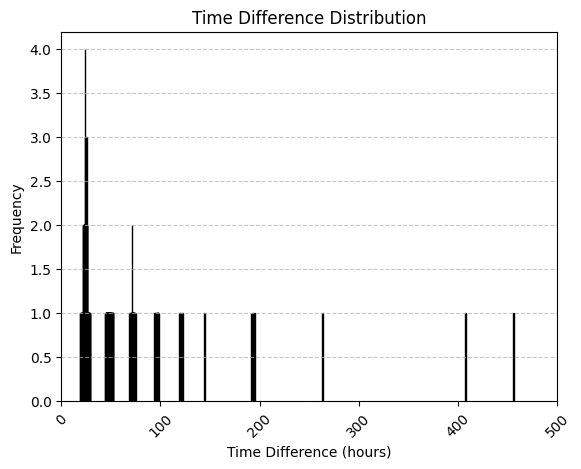

In [533]:
plot_time_spacing_distribution(df_time_diff)

In [534]:
filtered_df_time_diff = df_time_diff[df_time_diff["time_diffs_hours"] > 36]
filtered_df_time_diff

,Start,End,Sleep quality,Steps,Time in bed (hr),time_diffs_hours
24,2015-01-25 20:55:02,2015-01-26 06:14:59,0.87,NaN,9.316667,94.340833
26,2015-01-28 21:43:16,2015-01-29 05:20:42,0.76,NaN,7.616667,47.115278
29,2015-02-01 21:55:59,2015-02-02 05:09:06,0.64,NaN,7.216667,45.703611
33,2015-02-08 22:30:34,2015-02-09 06:48:30,0.89,NaN,8.283333,95.457778
38,2015-02-15 22:16:27,2015-02-16 05:20:44,0.74,NaN,7.066667,71.692500
...,...,...,...,...,...,...
1767,2022-03-16 21:59:05,2022-03-17 04:30:49,0.81,2339.0,6.528861,47.426111
1769,2022-03-19 23:41:34,2022-03-20 07:03:19,0.83,1985.0,7.362583,50.029722
1772,2022-03-23 22:30:25,2022-03-24 06:03:07,0.72,2521.0,7.545000,49.121111
1774,2022-03-26 21:14:23,2022-03-27 06:11:01,0.49,13388.0,8.943917,47.676944


In [535]:
df_time_diff.loc[23]

Start               2015-01-21 22:34:35
End                 2015-01-22 06:17:22
Sleep quality                      0.87
Steps                               NaN
Time in bed (hr)                    7.7
time_diffs_hours              24.866111
Name: 23, dtype: object

In [536]:
df_time_diff.loc[24]

Start               2015-01-25 20:55:02
End                 2015-01-26 06:14:59
Sleep quality                      0.87
Steps                               NaN
Time in bed (hr)               9.316667
time_diffs_hours              94.340833
Name: 24, dtype: object

In [537]:
df_time_diff.loc[25]

Start               2015-01-26 22:36:21
End                 2015-01-27 06:11:49
Sleep quality                      0.83
Steps                               NaN
Time in bed (hr)               7.583333
time_diffs_hours              25.688611
Name: 25, dtype: object

In [538]:
df_time_diff.loc[26]

Start               2015-01-28 21:43:16
End                 2015-01-29 05:20:42
Sleep quality                      0.76
Steps                               NaN
Time in bed (hr)               7.616667
time_diffs_hours              47.115278
Name: 26, dtype: object

### Baseline with pruned dataset

In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Start             1777 non-null   datetime64[ns]
 1   End               1777 non-null   datetime64[ns]
 2   Sleep quality     1777 non-null   float64       
 3   Steps             1360 non-null   float64       
 4   Time in bed (hr)  1777 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 69.5 KB


In [542]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Start             1333 non-null   datetime64[ns]
 1   End               1333 non-null   datetime64[ns]
 2   Sleep quality     1333 non-null   float64       
 3   Steps             924 non-null    float64       
 4   Time in bed (hr)  1333 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 52.2 KB


In [540]:
1777 -(1777 * 0.25)

1332.75

In [541]:
df_train = df.iloc[0:1333]
df_test = df.iloc[1333:]

In [543]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 1333 to 1776
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Start             444 non-null    datetime64[ns]
 1   End               444 non-null    datetime64[ns]
 2   Sleep quality     444 non-null    float64       
 3   Steps             436 non-null    float64       
 4   Time in bed (hr)  444 non-null    float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 17.5 KB


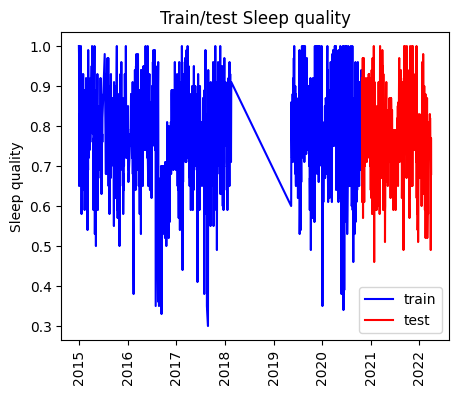

In [544]:
train_df_sort = df_train.sort_values(by="Start")
test_df_sort = df_test.sort_values(by="Start")

plt.figure(figsize=(5,4))
plt.plot(train_df_sort["Start"], train_df_sort["Sleep quality"], "b", label="train")
plt.plot(test_df_sort["Start"], test_df_sort["Sleep quality"], "r", label="test")
plt.xticks(rotation="vertical")
plt.legend()
plt.ylabel("Sleep quality")
plt.title("Train/test Sleep quality");


plot just connects each point, the gap is not being filled

#### baseline with no date

In [545]:
df.head()

,Start,End,Sleep quality,Steps,Time in bed (hr)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,1.00,NaN,8.533333
1,2014-12-30 22:42:49,2014-12-31 07:13:31,0.98,NaN,8.500000
2,2014-12-31 22:31:01,2015-01-01 06:03:01,0.65,NaN,7.533333
3,2015-01-01 22:12:10,2015-01-02 04:56:35,0.72,NaN,6.733333
4,2015-01-03 00:34:57,2015-01-03 07:47:23,0.83,NaN,7.200000


In [546]:
numeric_features = ["Steps", "Time in bed (hr)"]
categorical_features = []
drop_features = ["Start", "End"]
target = ["Sleep quality"]

In [547]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )

    preprocessor.fit(train_df)
    new_columns = preprocessor.get_feature_names_out()

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df[target[0]]
    y_test = test_df[target[0]]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [548]:
X_train_enc_baseline, y_train_baseline, X_test_enc_baseline, y_test_baseline, preprocesor =  preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features, target)

In [549]:
X_train_enc_baseline

,pipeline-1__Steps,pipeline-1__Time in bed (hr)
0,-0.102817,0.885747
1,-0.102817,0.843802
2,-0.102817,-0.372600
3,-0.102817,-1.379277
4,-0.102817,-0.792048
...,...,...
1328,-0.102817,0.746840
1329,-0.311554,0.432882
1330,-0.602168,-0.649645
1331,-0.243381,0.241753


In [550]:
dc = DummyRegressor()
dc.fit(X_train_enc_baseline, y_train_baseline)
dc.score(X_train_enc_baseline, y_train_baseline)

0.0

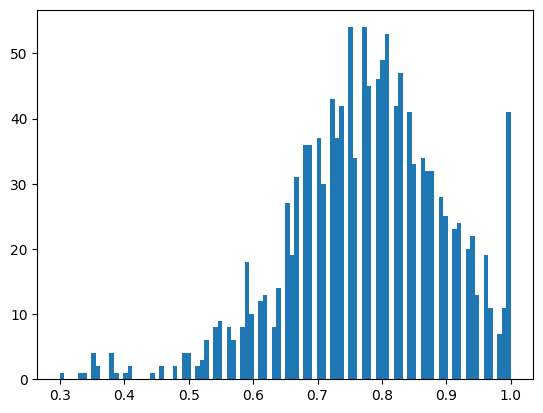

In [551]:
plt.hist(y_train_baseline, bins=100);

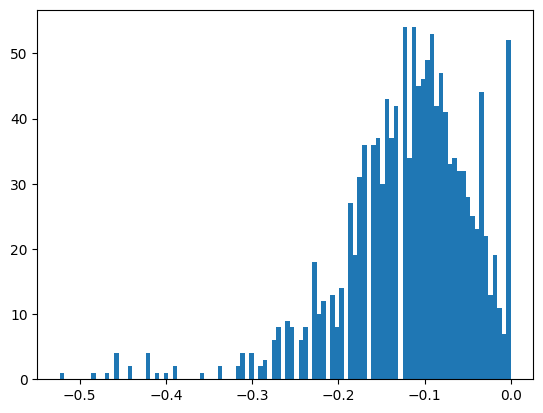

In [552]:
plt.hist(np.log10(y_train_baseline), bins=100);

no log transform needed (tried it with test data too, it has an even more normal distribution)

In [553]:
# Code credit: Adapted from
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/


def eval_on_features(
    X_train,
    X_test,
    y_train,
    y_test,
    regressor,
    xtick_labels = None,
    sales_data=False,
    ylabel="Sleep quality",
    feat_names="Default",
    impute=False,
):
    """
    Evaluate a regression model on a given set of features and target.

    This function splits the data into training and test sets, fits the
    regression model to the training data, and then evaluates and plots
    the performance of the model on both the training and test datasets.

    Parameters:
    -----------
    features : array-like
        Input features for the model.
    target : array-like
        Target variable for the model.
    regressor : model object
        A regression model instance that follows the scikit-learn API.
    n_train : int, default=184
        The number of samples to be used in the training set.
    sales_data : bool, default=False
        Indicates if the data is sales data, which affects the plot ticks.
    ylabel : str, default='Rentals'
        The label for the y-axis in the plot.
    feat_names : str, default='Default'
        Names of the features used, for display in the plot title.
    impute : bool, default=True
        whether SimpleImputer needs to be applied or not

    Returns:
    --------
    None
        The function does not return any value. It prints the R^2 score
        and generates a plot.
    """

    # Split the features and target data into training and test sets

    if impute:
        simp = SimpleImputer()
        X_train = simp.fit_transform(X_train)
        X_test = simp.transform(X_test)

    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Print R^2 scores for training and test datasets
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))

    # Predict target variable for both training and test datasets
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)

    # Plotting
    plt.figure(figsize=(10, 3))

    # # If not sales data, adjust x-ticks for dates (assumes datetime format)
    if not sales_data:
        tick_positions = list(range(0, len(y_train) + len(y_test), 50))
        tick_labels = xtick_labels[tick_positions].strftime("%y-%m-%d")
        plt.xticks(
            tick_positions,
            tick_labels,
            rotation=45,
            ha="left",
        )

    # Plot training and test data, along with predictions
    plt.plot(range(len(y_train)), y_train, label="train")
    plt.plot(range(len(y_train), len(y_test) + len(y_train)), y_test, "-", label="test")
    plt.plot(range(len(y_train)), y_pred_train, "--", label="prediction train")
    plt.plot(
        range(len(y_train), len(y_test) + len(y_train)), y_pred, "--", label="prediction test"
    )

    # Set plot title, labels, and legend
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

Train-set R^2: 0.19
Test-set R^2: 0.35


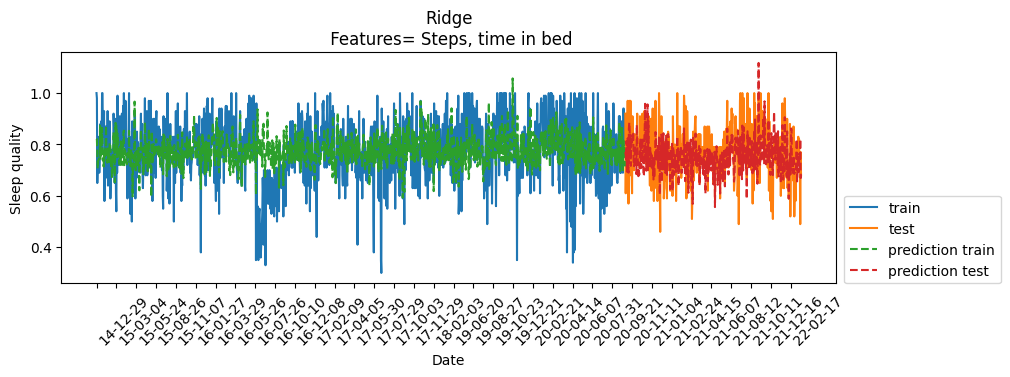

In [554]:
ridge = Ridge()
xtick_labels = pd.concat([df_train["Start"], df_test['Start']]).reset_index(drop=True)
xtick_labels = pd.DatetimeIndex(xtick_labels)
eval_on_features(X_train_enc_baseline, X_test_enc_baseline, y_train_baseline, y_test_baseline, ridge, xtick_labels=xtick_labels, feat_names="Steps, time in bed")


b